In [1]:
%set_env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from alibi.explainers.similarity.grad import GradientSimilarity

In [25]:
def plot_similar(ds, figsize=(20, 20)):
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(d['x'], cmap='gray')
        if j == 0:
            axes[j, 0].set_title("Original instance \n" + 
                                 "================ \n " + 
                                 f"Label: {d['y']} - Prediction: {d['pred']} ")
        else:
            axes[j, 0].set_title(f"Label: {d['y']} - Prediction: {d['pred']} ")
        for i in range(len(d['expl'].data['most_similar'])):
            axes[j, i + 1].imshow(d['expl'].data['most_similar'][i], cmap='gray')
            if j == 0:
                axes[j, i + 1].set_title(f"{i+1}{appendInt(i+1)} most similar instance \n" + 
                                         "================ \n " + 
                                         f"Label: {d['y_sim'][i]} - Prediction: {d['preds_sim'][i]}")
            else:
                axes[j, i + 1].set_title(f"Label: {d['y_sim'][i]} - Prediction: {d['preds_sim'][i]}")
    plt.show()


def plot_distributions(ds, figsize=(20, 20)):

    fig, axes = plt.subplots(5, 3, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 'scores': d['expl'].data['scores']})

        axes[i, 0].imshow(d['x'], cmap='gray')
        if i == 0:
            axes[i, 0].set_title("Original instance \n " + 
                                 "=================== \n " + 
                                 f"Label: {d['y']} - Prediction: {d['pred']} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - Prediction: {d['pred']}")        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[i, 1])
        if i == 0:
            axes[i, 1].set_title("Averaged scores for each true class in reference set \n" + 
                                 "================================== \n ")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[i, 2])
        if i == 0:
            axes[i, 2].set_title("Averaged scores for each predicted class in reference set \n" + 
                                 "================================== \n ")

    plt.show()

def appendInt(num):
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

## Load data

Loading and preparing the MNIST data set.

In [4]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Train a convolutional neural network on the MNIST dataset. The model includes 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `./model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [5]:
load_mnist_model = False
save_model = True

In [6]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

2022-04-27 11:05:24.198482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 11:05:24.203982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 11:05:24.204908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 11:05:24.206468: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/6


2022-04-27 11:05:25.661105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


235/235 [==============================] - 3s 8ms/step - loss: 0.5081 - accuracy: 0.8371 - val_loss: 0.1422 - val_accuracy: 0.9582
Epoch 2/6
235/235 [==============================] - 2s 7ms/step - loss: 0.1853 - accuracy: 0.9430 - val_loss: 0.0844 - val_accuracy: 0.9744
Epoch 3/6
235/235 [==============================] - 1s 6ms/step - loss: 0.1373 - accuracy: 0.9565 - val_loss: 0.0602 - val_accuracy: 0.9817
Epoch 4/6
235/235 [==============================] - 2s 7ms/step - loss: 0.1097 - accuracy: 0.9661 - val_loss: 0.0523 - val_accuracy: 0.9825
Epoch 5/6
235/235 [==============================] - 2s 7ms/step - loss: 0.0949 - accuracy: 0.9707 - val_loss: 0.0436 - val_accuracy: 0.9857
Epoch 6/6
235/235 [==============================] - 1s 6ms/step - loss: 0.0817 - accuracy: 0.9744 - val_loss: 0.0406 - val_accuracy: 0.9870


## Find similaraties 

In [7]:
model.loss

'categorical_crossentropy'

Initializing a `GradientSimilarity` explainer instance

In [8]:
gsm = GradientSimilarity(model, categorical_crossentropy, precompute_grads=True)

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [9]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref, y_ref = X_train[idxs_ref], y_train[idxs_ref]

Fitting the explainer on the reference data

In [10]:
gsm.fit(X_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_dot',
              'store_grads': True,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set

In [38]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

Getting the most similar instance for the each of the 5 test samples

In [39]:
ds = []
for j in range(len(X_sample)):
    expl = gsm.explain(X_sample[j], y_sample[j])
    y_sim = y_ref[expl.data['ordered_indices']].argmax(axis=1)
    X_sim = X_ref[expl.data['ordered_indices']]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j], 
         'y_sim': y_sim, 
         'preds_sim': preds_sim, 
         'expl': expl}
    ds.append(d)

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

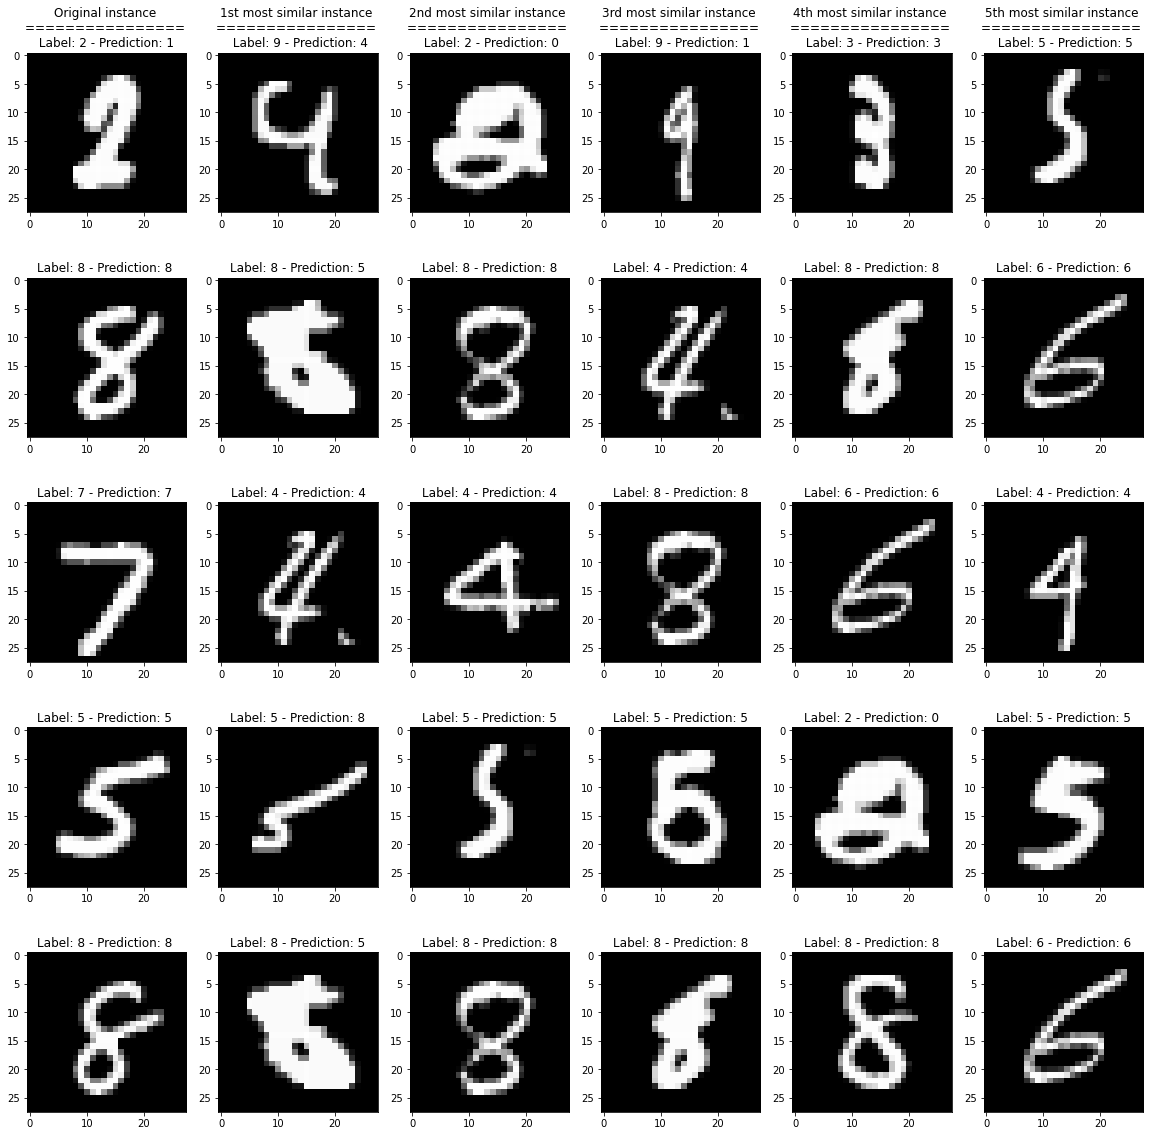

In [42]:
plot_similar(ds)

## Most similar labels distributions 

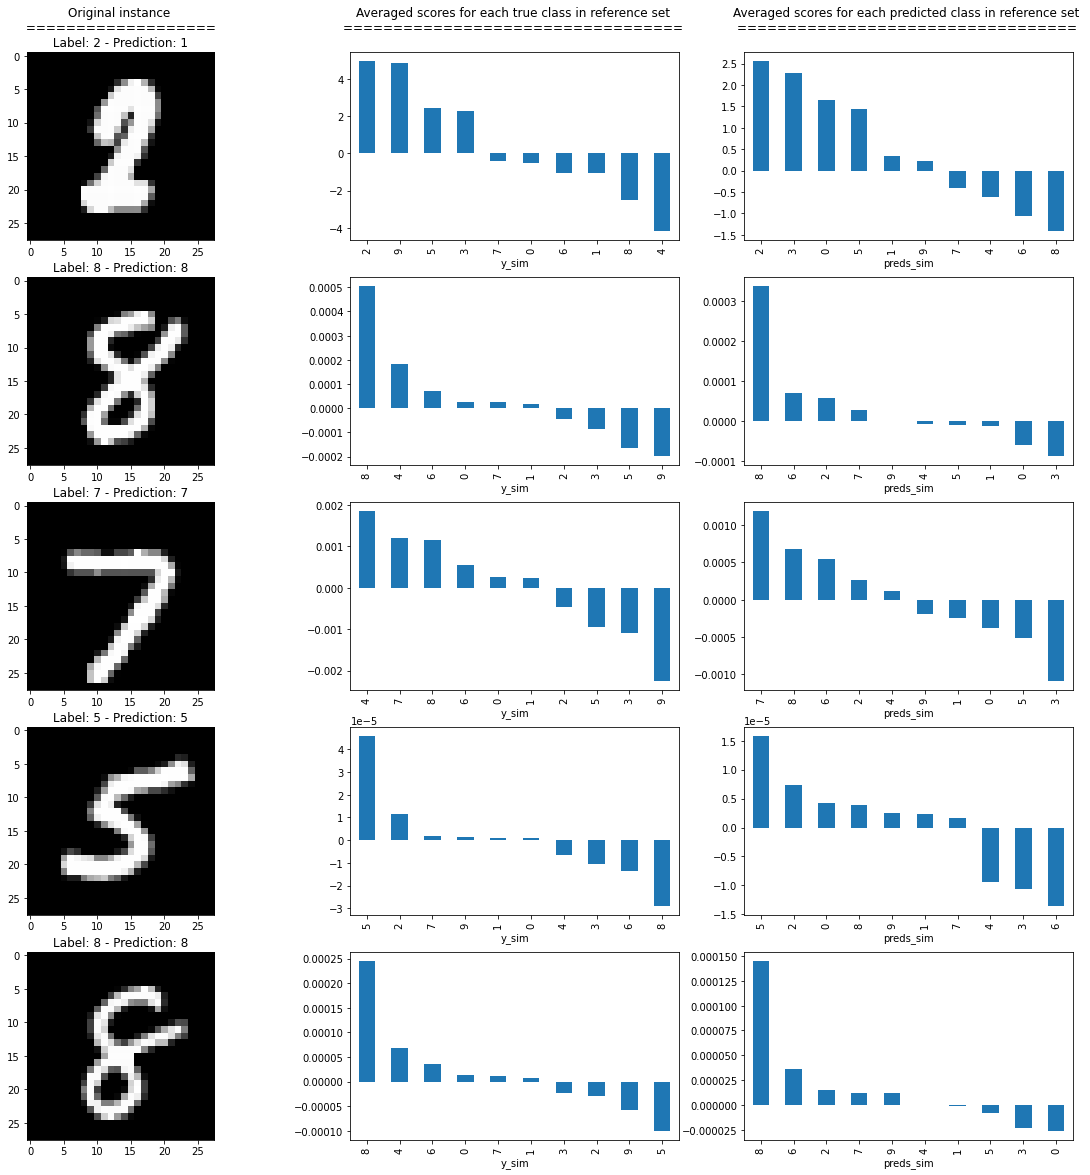

In [43]:
plot_distributions(ds)

In [44]:
# try try 